# Measuring spectra

In this example, we will use the [*Heracles*](https://heracles.readthedocs.io) code to measure the angular power spectra of our simulated galaxy survey. By comparing measurements and predictions from theory, we can learn something about cosmology.

## Set up

Some required imports, nothing fancy.

In [1]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

Now the Heracles imports:

* The top-level `heracles` module contains all general user-facing functionality.
* The `heracles.healpy` module contains functionality for mapping catalogues to HEALPix maps with the `healpy` package.
* The `heracles.notebook` module contains a progress bar for Jupyter/IPython notebooks, using the `ipywidgets` package.

In [2]:
import heracles
import heracles.healpy
from heracles.notebook import Progress

## Tomographic redshift bins

To extract more information from photometric galaxy surveys, the catalogue is usually split up into "slices" along the line of sight, the so-called tomographic redshift bins.
Before we can start analysing our catalogue, we have to define which tomographic redshift binning is to be used.

To do so, we load the catalogue, and split the entire sample up into 6 equal-density slices, using the photometric redshift from the `"PHZ"` column.

In [3]:
# read catalogue
cat = fitsio.read("catalog.fits")

# number of tomographic bins
nbin = 6

# tomographic redshift bin edges with equal number density
zbins = np.quantile(cat["PHZ"], np.linspace(0.0, 1.0, nbin + 1))

The tomographic redshift bin edges are all we need to split the catalogue into `nbin` individual selections.

In [4]:
zbins

array([2.29062729e-05, 5.99987664e-01, 8.31252702e-01, 1.04654674e+00,
       1.28845510e+00, 1.62225091e+00, 3.43605664e+00])

However, to compute theoretical expectations, we also need to reconstruct the redshift distribution $n(z)$ in each tomographic bin. Here, we simply use the `"REDSHIFT"` column, which contains each galaxy's true redshift. In a real galaxy survey, this step is a massively complicated problem.

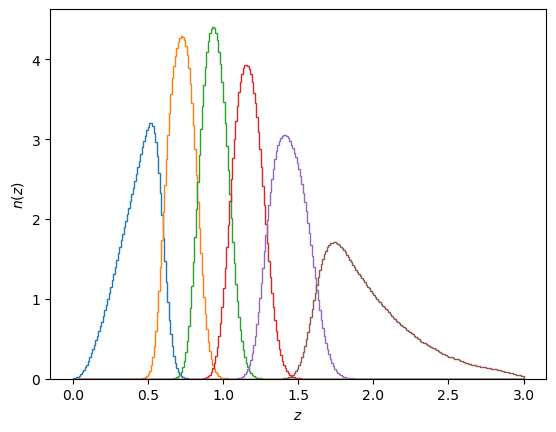

In [5]:
# create the redshift grid
z = np.linspace(0.0, 3.0, 301)

# create the tomographic n(z)
nz = np.empty((nbin, z.size - 1))
for i, z1, z2 in zip(range(nbin), zbins, zbins[1:]):
    # only select galaxies with z1 <= PHZ < z2
    selection = (z1 <= cat["PHZ"]) & (cat["PHZ"] < z2)
    nz[i], _ = np.histogram(cat["REDSHIFT"][selection], bins=z, density=True)

# plot the resulting distributions
for i in range(nbin):
    plt.stairs(nz[i], z)
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

> Where does the overlap in the tomographic n(z) come from?

For future reference, store the tomographic redshift distribution

In [6]:
np.savez("nz.npz", z=z, nz=nz)

From now on, we no longer need the full catalogue, as we will be using Heracles' functionality for the rest.

In [7]:
del cat

## Catalogues

Heracles provides a flexible interface for loading catalogues from FITS files or arrays. It also provides a base that can quickly be extended e.g. to databases or more.

Here we use the FITS interface to read a catalogue from file. We could specify the columns to read, but we don't do that here, because the catalogue only has columns of interest here.

To be able to process the largest galaxy surveys, catalogues are never read into memory all at once. Their `page_size` property determines how many rows are read as one "page" at a time.

In [8]:
# create the FITS catalogue
catalog = heracles.FitsCatalog("catalog.fits")

Using the `add_filter()` method, we could add filters to the catalogue here which, e.g., strip rows with invalid values, or apply an extra footprint mask to the catalogue. Since we made our catalogue ourselves, that won't be necessary here.

## Footprint

Some statistics and normalisations require knowledge of the survey footprint. We load our previously saved footprint map and associate it with the catalogue.

In [9]:
# set visibility of the catalogue
catalog.visibility = hp.read_map("footprint.fits.gz")

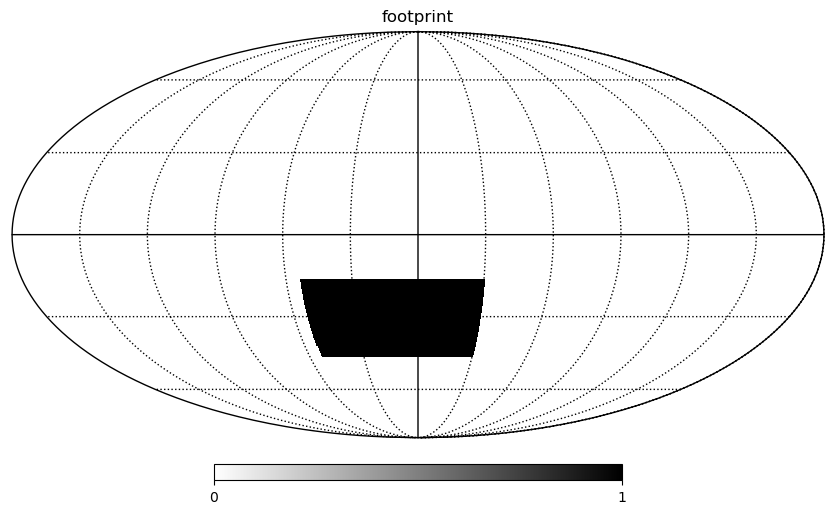

In [10]:
# make sure the map is as expected
hp.mollview(catalog.visibility, title="footprint", cmap="binary")
hp.graticule()
plt.show()

## Tomographic binning

The `catalog` object as it is would read the entire catalogue.
To split the catalogue up into our individual tomographic bins, we construct a dictionary that assigns a bin ID to a subselection of the catalogue. This is done using the usual `[...]` syntax, which returns a new view of the catalogue with the given selection applied.

In [11]:
catalogs = {
    binid: catalog[f"({z1} <= PHZ) & (PHZ < {z2})"]
    for binid, z1, z2 in zip(range(1, 7), zbins, zbins[1:])
}

In [12]:
catalogs

{1: catalog.fits['(2.2906272887321166e-05 <= PHZ) & (PHZ < 0.5999876643368878)'],
 2: catalog.fits['(0.5999876643368878 <= PHZ) & (PHZ < 0.8312527021043702)'],
 3: catalog.fits['(0.8312527021043702 <= PHZ) & (PHZ < 1.0465467365027006)'],
 4: catalog.fits['(1.0465467365027006 <= PHZ) & (PHZ < 1.2884551036080785)'],
 5: catalog.fits['(1.2884551036080785 <= PHZ) & (PHZ < 1.6222509113716925)'],
 6: catalog.fits['(1.6222509113716925 <= PHZ) & (PHZ < 3.4360566425962125)']}

## Fields

To turn catalogues into spectra, Heracles requires a so-called mapper object.
Here, we construct a `HealpixMapper` instance with our desired NSIDE (i.e., resolution) and LMAX (i.e., number of angular modes) parameters.

In [13]:
# resolution and angular modes
nside = 1024
lmax = 2000

In [14]:
# construct a mapper that produces HEALPix maps
mapper = heracles.healpy.HealpixMapper(nside, lmax)

To specify the fields we wish to analyse, we construct a dictionary of keys and field definitions.
A field requires a mapper and a list of columns, plus potentially some other options.

Here, we construct a field `"G"` for our simulated cosmic shear, using the column names from the catalogue that we wrote. The `mask="W"` parameter can be ignored for the time being.

In [15]:
# construct a dictionary for the fields to be analysed
fields = {
    "G": heracles.Shears(mapper, "RA", "DEC", "E1", "E2", "WEIGHT", mask="W"),
}

## Mapping

The next step is to map the catalogues to the shear field for each tomographic bin. Heracles can map a set of catalogues all at once, using the `map_catalogs()` function. We only need to pass in the fields and catalogues constructed previously.

In [16]:
# create tomographic maps from fields and catalogs
with Progress("mapping") as progress:
    maps = heracles.map_catalogs(fields, catalogs, parallel=True, progress=progress)

VBox()

The resulting `maps` dictionary has keys consisting of the field (`"G"`) and catalogue (`1`, `2`, ...), and values which are two HEALPix maps for the two shear components.

In [17]:
for key, value in maps.items():
    print("key", key, "contains maps of shape", value.shape)

key ('G', 1) contains maps of shape (2, 12582912)
key ('G', 2) contains maps of shape (2, 12582912)
key ('G', 3) contains maps of shape (2, 12582912)
key ('G', 4) contains maps of shape (2, 12582912)
key ('G', 5) contains maps of shape (2, 12582912)
key ('G', 6) contains maps of shape (2, 12582912)


Let's have a quick look at the results in bin 3!

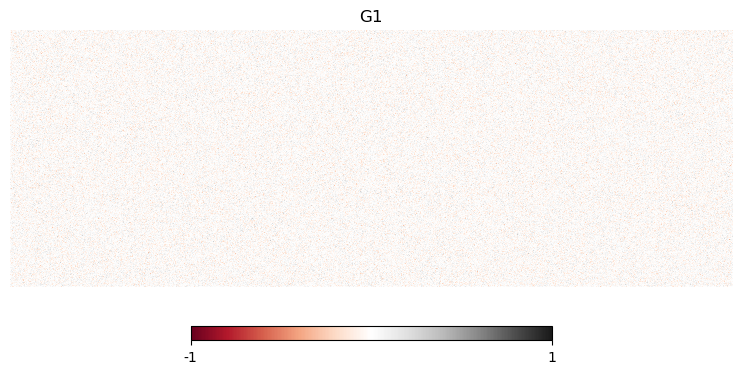

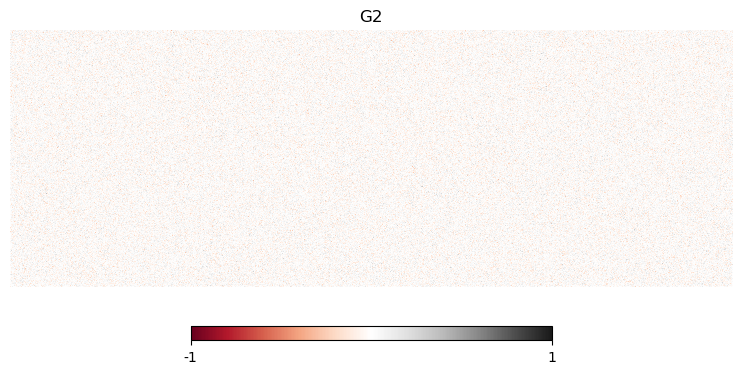

In [18]:
binid = 3

hp.cartview(maps["G", binid][0], title="G1", cmap='RdGy', min=-1.0, max=1.0,
            lonra=[329.5, 53.5], latra=[-45.6, -15.7])
plt.show()

hp.cartview(maps["G", binid][1], title="G2", cmap='RdGy', min=-1.0, max=1.0,
            lonra=[329.5, 53.5], latra=[-45.6, -15.7])
plt.show()

> Why is the shear map so close to zero everywhere? Does the look of the map depend on your analysis choices?

## Spherical harmonic coefficients

To extract the two-point information, we transform the real-space maps we created into harmonic space using the `transform()` function.

In [19]:
# transform maps to harmonic space, using the mapper from fields
with Progress("transform") as progress:
    alms = heracles.transform(fields, maps, progress=progress)

VBox()

The resulting `alms` dictionary has the same keys as `maps`, but now contains the spherical harmonic coefficients in the particular format that HEALPix uses, which has become the de facto standard. As with the maps, there are two sets of coefficients for each tomographic bin, containing the *E*-mode and *B*-mode of the field.

In [20]:
for key, value in alms.items():
    print("key", key, "contains alms of shape", value.shape)

key ('G', 1) contains alms of shape (2, 2003001)
key ('G', 2) contains alms of shape (2, 2003001)
key ('G', 3) contains alms of shape (2, 2003001)
key ('G', 4) contains alms of shape (2, 2003001)
key ('G', 5) contains alms of shape (2, 2003001)
key ('G', 6) contains alms of shape (2, 2003001)


## Two-point statistics

We are now able to compute the two-point statistics in the form of angular power spectra. To do so, we simply call the `angular_power_spectra()` function on `alms`. The function removes the noise bias from the spectra (unless `debias=False` is passed) and can optionally compute binned spectra (using the `bins=` and `weights=` parameters).

In [21]:
# compute spectra from all combinations of alms
cls = heracles.angular_power_spectra(alms)

This returns all combinations of spherical harmonic coefficients. They are many, arranged in a dictionary with entries such as `("G_E", "G_B", 5, 4) for the *E*-mode and *B*-mode cross-power spectrum between bin IDs 5 and 4 (in order).

In [22]:
print("there are", len(cls), "spectra, starting with", list(cls.keys())[:3])

there are 78 spectra, starting with [('G_E', 'G_E', 1, 1), ('G_E', 'G_B', 1, 1), ('G_E', 'G_E', 1, 2)]


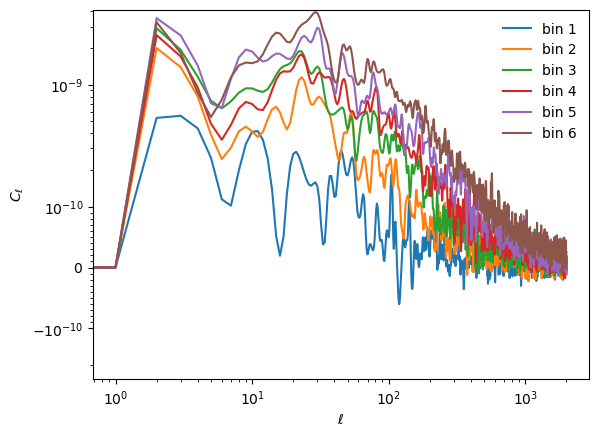

In [23]:
# print the spectra of the E-mode auto-correlations
for binid in range(1, 7):
    plt.plot(
        np.arange(lmax + 1),
        cls["G_E", "G_E", binid, binid],
        label=f"bin {binid}",
    )
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell$")
plt.show()

> Why does the signal suddenly drop to zero on the left?

## Theory

We can now compute the theoretical expectation of the angular power spectra. To do so, we use CAMB again.

In [24]:
import camb
from camb.sources import SplinedSourceWindow

# cosmology for the analysis
h = 0.67
Oc = 0.27
Ob = 0.05
As = 2.2e-9

# set up CAMB parameters
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, As=As,
                       NonLinear=camb.model.NonLinear_both)
pars.min_l = 1
pars.Want_CMB = False
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

We load the tomographic redshift distribution of the simulation, and use it to create window functions for the theory lensing spectra.

In [25]:
# centres of the redshift bins
zmid = (z[:-1] + z[1:]) / 2

# create distributions for CAMB
sources = []
for i in range(nbin):
    source = SplinedSourceWindow(source_type='lensing', z=zmid, W=nz[i])
    sources.append(source)
pars.SourceWindows = sources

Compute the full sky theory spectra up to `lmax`.

In [26]:
# compute spectra with CAMB, using raw_cl to remove l*(l+1) scaling
camb_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

CAMB's lensing spectra are for the convergence, not the shear. We can compute an ell-dependent scaling that converts between the two.

In [27]:
ell = np.arange(lmax + 1)
fl = -np.sqrt((ell + 2) * (ell + 1) * ell * (ell - 1))
fl /= np.clip(ell * (ell + 1), 1, None)

To make the comparison easier, we can store the CAMB results in the same dictionary structure as our measurement.

In [28]:
# build the dictionary with keys like Heracles does
theory_cls = {}
for i in range(1, nbin + 1):
    for j in range(i, nbin + 1):
        # what CAMB calls the sources
        cl = camb_cls[f"W{i}xW{j}"]

        # include the conversion factor in the E-mode spectrum
        theory_cls["G_E", "G_E", i, j] = cl * fl**2

        # theory predicts zero B-modes to a very good approximation
        theory_cls["G_B", "G_B", i, j] = np.zeros(lmax + 1)
        theory_cls["G_E", "G_B", i, j] = np.zeros(lmax + 1)
        theory_cls["G_B", "G_E", i, j] = np.zeros(lmax + 1)

Finally, we can compare our measurements with the expectation!

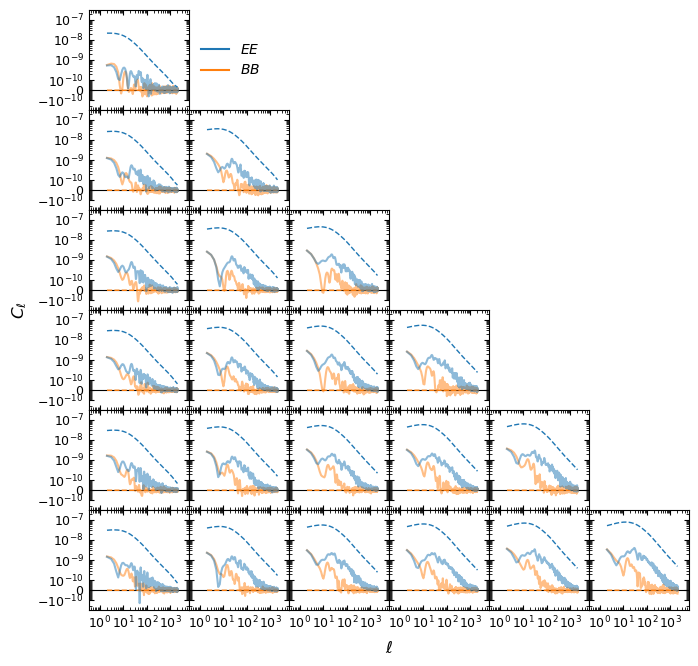

In [29]:
def plot_spectra(spectra, theory):
    """
    Plot a set of angular power spectra.
    """

    fig, ax = plt.subplots(nbin, nbin, figsize=(nbin, nbin), sharex=True, sharey=True)
    fig.tight_layout(pad=0.0)
    
    for i in range(1, nbin + 1):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbin + 1):
            ax[j - 1, i - 1].plot(ell[2:], spectra["G_E", "G_E", i, j][2:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
            ax[j - 1, i - 1].plot(ell[2:], spectra["G_B", "G_B", i, j][2:], c="C1", lw=1.5, zorder=1.0, alpha=0.5)
            ax[j - 1, i - 1].plot(ell[2:], theory["G_E", "G_E", i, j][2:], c="k", lw=0.5, zorder=4.0)
            ax[j - 1, i - 1].plot(ell[2:], theory["G_B", "G_B", i, j][2:], c="k", lw=0.5, zorder=2.0)
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in", labelsize=9.0,
                                         top=True, bottom=True, left=True, right=True)
    
    ax[0, 1].legend(
        handles=[
            plt.Line2D([0], [0], c="C0", lw=1.5, label="$EE$"),
            plt.Line2D([0], [0], c="C1", lw=1.5, label="$BB$"),
            plt.Line2D([0], [0], c="k", lw=0.5, label="theory"),
        ],
        loc="center left",
        frameon=False,
    )
    
    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
    ax[0, 0].set_yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
    ax[0, 0].set_ylim(-3e-10, 3e-8)
    
    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
    
    fig.supxlabel("$\\ell$", y=-0.05, va="top")
    fig.supylabel("$C_\\ell$", x=-0.1, ha="right")

    return fig, ax


plot_spectra(cls, theory_cls)
plt.ylim(-3e-10, 3e-7)
plt.show()

As we can see, our measurement does not match expectations at all!

> What two major discrepancies do you see between theory and observations?

> What is the ratio between theory and observation for the *EE* spectrum? Does this number remind you of something you calculated earlier?

## Mixing matrices

Spectra, either on the sphere or in Cartesian space, are obtained from a transform of the signal that integrates over the entire space.
Therefore, unless your observations are available everywhere, the observed spectra are effectively those of the product of signal and a window function.
In Cartesian space, the convolution theorem tells us that the Fourier transform $\mathcal{F}$ of the product of functions $f$ and $g$ is
$$
    \mathcal{F}[fg] = \mathcal{F}[f] \circ \mathcal{F}[g] \,,
$$
and the same holds true for the spherical harmonic transform on the sphere.
The survey footprint therefore changes our spherical harmonic modes by convolution.
At the level of the power spectra, the effect is a "mixing" of the modes by linear combination, which can be described by a so-called "mixing matrix".
The mixing matrix $M$ takes a full-sky power spectrum $C_\ell$ and produces a partial-sky power spectrum $\tilde{C}_\ell$:
$$
    \tilde{C}_\ell = \sum_{\ell' = 0}^{\infty} M_{\ell\ell'} \, C_{\ell'}
$$

To zero order, the effect of the mixing matrix is that it scales the spectra by the sky fraction of the footprint ("fsky"). In particular, this approximation is often used for computing covariance matrices, where mode mixing is much more complicated. We can test this approximation easily.

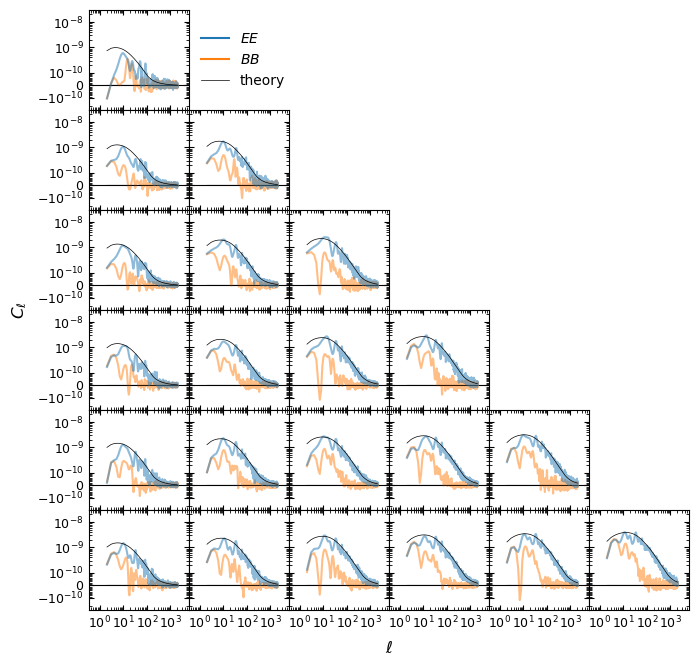

In [30]:
# compute the spectra with fsky correction
model_cls = {}
for i in range(1, 7):
    for j in range(i, 7):
        model_cls["G_E", "G_E", i, j] = catalog.fsky * theory_cls["G_E", "G_E", i, j]
        model_cls["G_B", "G_B", i, j] = catalog.fsky * theory_cls["G_B", "G_B", i, j]
        model_cls["G_E", "G_B", i, j] = catalog.fsky * theory_cls["G_E", "G_B", i, j]
        model_cls["G_B", "G_E", i, j] = catalog.fsky * theory_cls["G_B", "G_E", i, j]

plot_spectra(cls, model_cls)
plt.show()

> What do you think of this approximation? What does it fix? What does it not fix?

To properly account for the mode mixing induced by the window function, we now compute the mixing matrices. Do do so, we first need to compute the angular power spectra of the window function. Our cosmic shear maps here are weighted maps, where each galaxy contributes (weight) × (shear). The window function is hence the map of shear weights, which we construct now using *Heracles* in the same manner as above.

Although it is called a mixing "matrix", in reality it is an infinitely-dimensional linear operator that maps the $\ell_2 = 0, 1, 2, \ldots$ modes of the full-sky spectrum to the $\ell_1 = 0, 1, 2, \ldots$ modes of the partial-sky spectrum. It only turns into a matrix if we truncate it at mode numbers `l1max` and `l2max`, respectively. Here, we truncate both at `lmax`, which produces a square mixing matrix. Due to the particular form that the mode mixing takes in harmonic space, that means we need window function spectra with modes up to `l3max = l1max + l2max`, which here is `2 * lmax`. To get these, we create a new mapper with the requisite `nside` and `lmax` values.

In [31]:
# mapper using twice the resolution and max scale
mapper2 = heracles.healpy.HealpixMapper(2 * nside, 2 * lmax)

Next, we need to create a field for the weight maps, using the same column names as above. If you remember the shear field definition, it used a `mask="W"` parameter; that is the name of the field we are creating now.

In [32]:
# fields for weights
fields2 = {
    "W": heracles.Weights(mapper2, "RA", "DEC", "WEIGHT"),
}

We then compute the weight maps ...

In [33]:
with Progress("mapping") as progress:
    maps2 = heracles.map_catalogs(fields2, catalogs, parallel=True, progress=progress)

VBox()

transform the maps into spherical harmonics ...

In [34]:
with Progress("transform") as progress:
    alms2 = heracles.transform(fields2, maps2, progress=progress)

VBox()

and finally compute the spectra of the weights.

In [35]:
cls2 = heracles.angular_power_spectra(alms2)

Using the spectra of the weight maps (i.e., window functions), we can compute the mixing matrices for cosmic shear.
Since each tomographic bin has different shears with different weights, we need to compute a mixing matrix for each spectrum, i.e., each bin combination.
This may take a while.

In [36]:
with Progress("mixing matrices") as progress:
    mms = heracles.mixing_matrices(fields, cls2, l1max=lmax, l2max=lmax, progress=progress)

VBox()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Once the mixing matrices are computed, we can apply them to the theoretical full-sky spectra. Note the mixing between *E*-modes and *B*-modes, which in principle would mix both *E*-modes into *B*-modes and *B*-modes into *E*-modes, except that full-sky *B*-modes are zero.

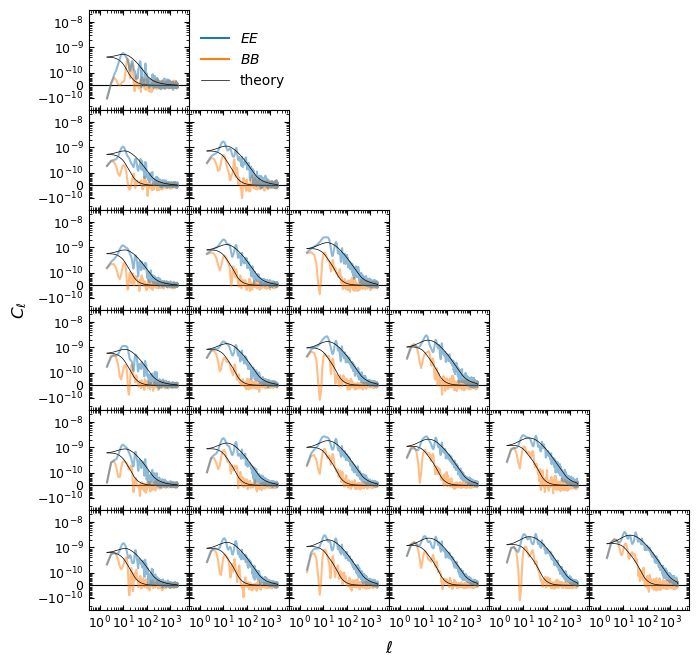

In [37]:
# compute the spectra while modelling the impact of the mask
model_cls = {}
for i in range(1, 7):
    for j in range(i, 7):
        cl_ee = theory_cls["G_E", "G_E", i, j]
        cl_bb = theory_cls["G_B", "G_B", i, j]
        cl_eb = theory_cls["G_E", "G_B", i, j]
        cl_be = theory_cls["G_B", "G_E", i, j]
        model_cls["G_E", "G_E", i, j] = mms["G_E", "G_E", i, j] @ cl_ee + mms["G_B", "G_B", i, j] @ cl_bb
        model_cls["G_B", "G_B", i, j] = mms["G_B", "G_B", i, j] @ cl_ee + mms["G_E", "G_E", i, j] @ cl_bb
        model_cls["G_E", "G_B", i, j] = mms["G_E", "G_B", i, j] @ cl_eb
        model_cls["G_B", "G_E", i, j] = mms["G_E", "G_B", i, j] @ cl_be

plot_spectra(cls, model_cls)
plt.show()

These results now agree nicely with theory. Well done!

## Inference

We could, at this point, use our measurement and theoretical prediction to run an inference pipeline for the cosmological parameters. While we don't have the time to do this properly, we can still do a little experiment.

> If you look very carefully at our last plot, you might notice that there is still a small but systematic discrepancy between theory and observation. The reason is in this notebook. Can you find it?

<details>
<summary>Bonus question: Only open this after you tried your hand at the previous question.</summary>

> You will have seen that we are using different cosmology parameters here than in the simulation. In particular, we are also setting the `As` parameter to a value here, but left it at its default value in the simulation. Restoring the other parameters to their simulated values, can you discover what CAMB's default value of `As` might be without looking it up?

</details>